***Colorizer***

**Preparation**

In [15]:
#Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image, ImageCms
from PIL import ImageOps
from skimage import color, io
%matplotlib inline

In [16]:
#Device
device = torch.device('cuda:0')

In [17]:
#Посмотрим на размер датасета
filenames = []
for root, dirs, files in os.walk('../input/data-coloring/universum-photos'):
  for file in files:
    if file.endswith('.jpg') or file.endswith('.JPG'):
      filenames.append(os.path.join(root, file))
len(filenames)

1254

In [18]:
#Очевидно, что такого количества данных недостаточно, чтобы нейронная сеть смогла решить поставленную задачу. К тому же, мы должны учесть, что часть картинок может быть битой и 
#поэтому не будет являться валидными датапоинтами. Найдем количество валидных датапоинтов, которые мы сможем использовать при обучении сети.
images = []
for filename in tqdm(filenames):
  try:
    with Image.open(filename) as image:
      images.append(image.copy().convert('RGB'))
  except:
    pass
len(images)

100%|██████████| 1254/1254 [00:10<00:00, 119.93it/s]


1015

In [19]:
#В конечном итоге из-за наличия битых картинок было потеряно еще около 20% данных. Таким образом, конечный объем датасета это 1015 сэмплов, что мало для нашей задачи. Это первая
#проблема, которую будет необходимо как-либо решить до обучения сети.
print(f"{round(100 - len(images) * 100 /len(filenames))}%")

19%


In [20]:
#Но проблема размера датасета, скорее всего, является не единственной в нашей задаче. Например, размеры картинок могут быть не одинаковые, что помешает нам пакетировать их. 
#Чтобы это доказать, нужно найти 2 картинки с разными размерами. Возьмем две случайные и посмотрим на их размер.
print(f"size 1 - {images[torch.randint(1015, (1, ))[0].item()].size}, size 2 - {images[torch.randint(1015, (1, ))[0].item()].size}")

size 1 - (256, 171), size 2 - (256, 192)


In [21]:
#Размеры картинок отличаются => проблема с разными размерами картинок становится второй проблемой, которую нужно будет решить в дальнейшем. Таким образом, мы нашли два очевидныx
#проблематичных вопроса, на которые необходимо найти ответ ДО обучения нейронной сети.   

In [22]:
#Займемся первой проблемой датасета. Для того, чтобы побороться с этой проблемой, мы можем расширить обучающую выборку с помощью аугментации данных. В нашем случае аугментация 
#будет заключаться в различных преобразованиях картинки: поворот, сжатие, изменение контраста и тд. Рассмотрим самые часто использующиеся преобразования и
#выберем наиболее подходящие под нашу задачу. Конечно, можно было бы попробовать все преобразования, но так как сеть в данной задаче долго обучается, лучше будет сразу задуматься
#о пользе/вреде тех или иных трансформаций.

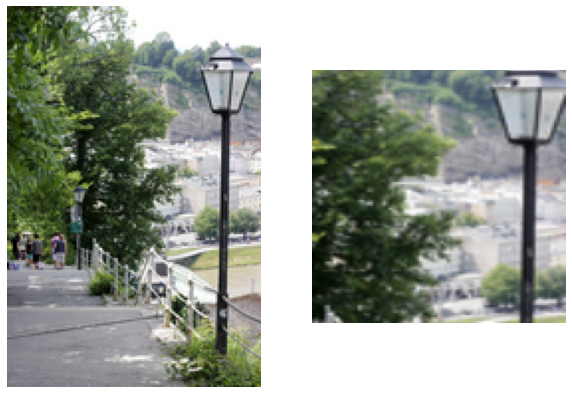

In [23]:
#Crop +
#Я добавлю это преобразование в конечную последовательность преобразований, потому что оно решает сразу две задачи: 1)аугментация 2)стандартизация размера всех картинок.
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.axis('off')
plt.imshow(images[230])

plt.subplot(122)
plt.axis('off')
plt.imshow(transforms.RandomResizedCrop(128)(images[230]))
    
plt.show()

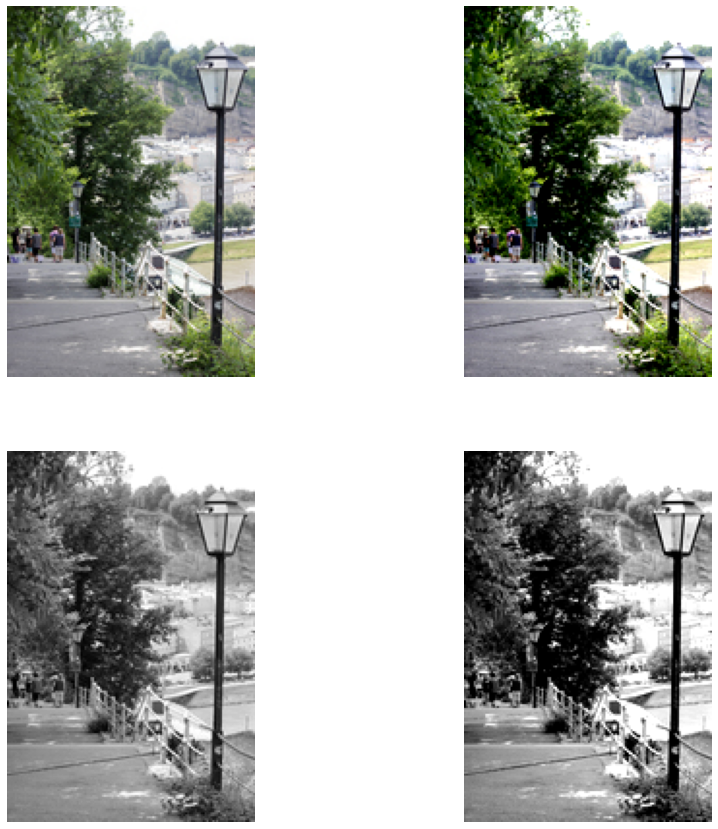

In [24]:
#Contrast -
#В этом преобразовании нет какого-либо смысла, потому что вообще мы хотим научить модель красить чб изображение в исходный датапоинт, используя палитру исходного датапоинта, но 
#если мы применяем изменение контраста, то палитра нашего исходного датапоинта меняется. К тому же, очевидно, что нам не важно, покрасит нейронка футболку в темно-синий или просто 
#синий, нам важно именно то, что сеть нашла футболку на картинке и покрасила ее в какой-то из оттенков синего, а аугментация с помощью увеличения/уменьшения контраста цветов на 
#картинке вряд-ли нам в этом поможет.
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.axis('off')
plt.imshow(images[230])

plt.subplot(222)
plt.axis('off')
plt.imshow(transforms.functional.adjust_contrast(images[230], contrast_factor=1.5))

plt.subplot(223)
plt.axis('off')
plt.imshow(transforms.functional.to_grayscale(images[230]), cmap='gray')

plt.subplot(224)
plt.axis('off')
plt.imshow(transforms.functional.to_grayscale(transforms.functional.adjust_contrast(images[230], contrast_factor=1.5)), cmap='gray')


    
plt.show()

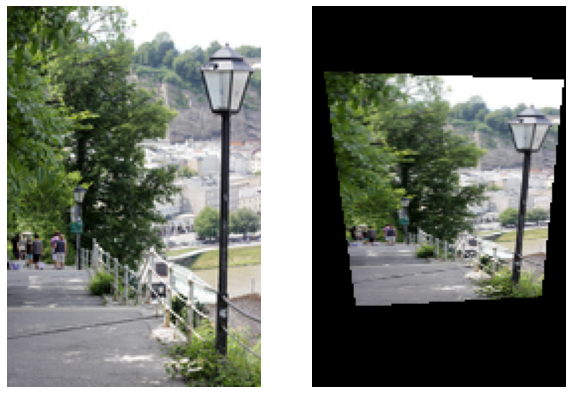

In [26]:
#Perspective -
#Это мощное преобразование, которое позволяет сделать модель очень устойчивой к различным поворотам-проекциям картинки.Однако, на мой взгляд, сети лучше дать 
#повернутую+флипнутую картинку, потому что проекция картинки является более сложной вариацией картинки(в сравнении с повернутой+флипнутой картинкой) => нейронная сеть будет 
#дольше находить паттерны на таком трудном датапоинте, чем на более простом и прямолинейном, но в то же время дающим почти ту же устойчивость сети, датапоинте.
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.axis('off')
plt.imshow(images[230])

plt.subplot(122)
plt.axis('off')
plt.imshow(transforms.RandomPerspective()(images[230]))
    
plt.show()

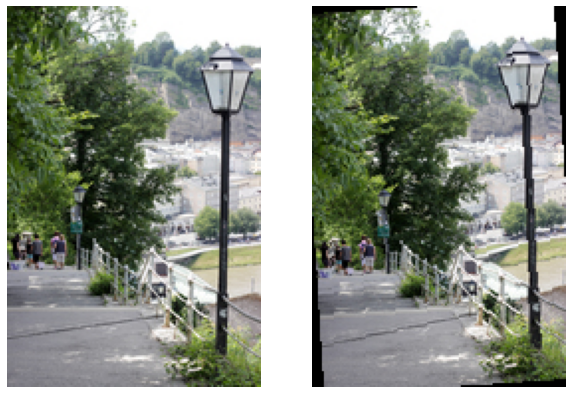

In [27]:
#Rotation +
#Я добавлю это преобразование в конечную последовательность преобразований, потому что оно позволяет получить много новых датапоинтов из 
#одного датапоинта. В теории, если выбирать угол из непрерывного промежутка, то количество новых датапоинтов равно inf. Однако, на мой взгляд,
#это ухудшит результаты нейронной сети, так как она каждый раз будет видеть картинку в под новым углом, что усложнит ей задачу распознавания 
#различных паттернов на картинке. Поэтому напишем свою ф-ю для поворота на угол, который выбирается из конечного множества.
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.axis('off')
plt.imshow(images[230])

plt.subplot(122)
plt.axis('off')
plt.imshow(transforms.RandomRotation((-15, 15))(images[230]))
    
plt.show()

In [28]:
#My rotation 
def my_rotation(img):
  angle = np.array([-15, -10, -5, 0, 5, 10, 15])
  return transforms.functional.rotate(img, int(np.random.choice(angle)))

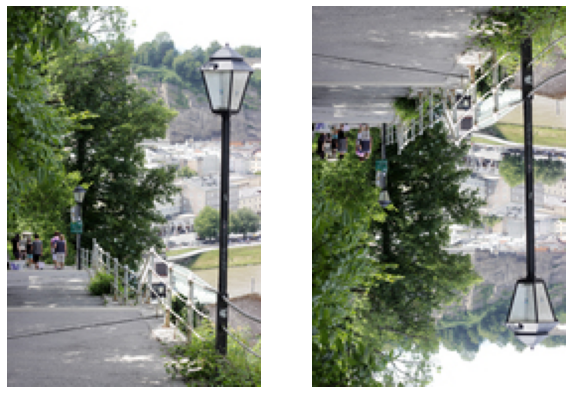

In [35]:
#RandomVerticalFlip - 
#Я не буду добавлять это преобразование, потому что, на мой взгляд, оно добавляет слишком трудные вариации картинки. Т.е какие-либо паттерны на флипнутой по вертикали картинке найти 
#труднее, чем на повернутой на небольшой угол или флипнутой по горизонтали.
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.axis('off')
plt.imshow(images[230])

plt.subplot(122)
plt.axis('off')
plt.imshow(transforms.RandomVerticalFlip()(images[230]))
    
plt.show()

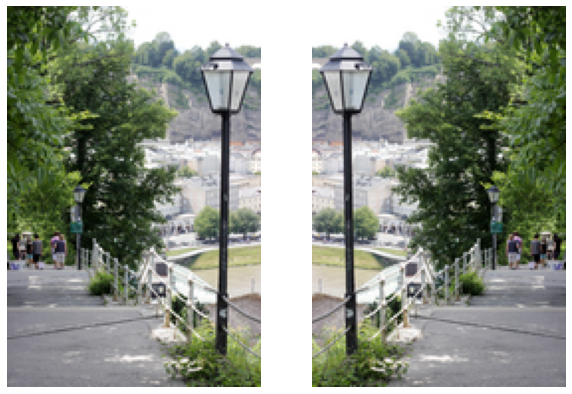

In [30]:
#RandomHorizontalFlip + 
#Я добавлю это преобразование в конечную последовательность преобразований после поворота, потому что оно позволяет расширить количество новых повернутых картинок:
#например, если угол поворота лежит в промежутке <-pi/6, pi/6>, то если использовать флип после поворота, мы можем получить картинки с под углами <-pi/6, pi/6>, <5pi/6, 7pi/6>.
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.axis('off')
plt.imshow(images[230])

plt.subplot(122)
plt.axis('off')
plt.imshow(transforms.RandomHorizontalFlip()(images[230]))
    
plt.show()

In [31]:
#Crop +
#Contrast -
#Perspective -
#My rotation +
#RandomVerticalFlip - 
#RandomHorizontalFlip + 
#Составим из выбранных трансформаций последовательность преобразований, которая будет применяться к каждому изображению. Также не забудем, что нам еще нужна функция, которая будет
#из исходной цветной картинки делать чб.

In [36]:
#Transform 
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    my_rotation,
    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
])


In [37]:
#sRGB image convert to grayscale 
def to_grayscale_srgb(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [38]:
#Transform after fitting 
transform_after_fitting = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.ToTensor(),
])

In [39]:
#Учитывая то, что мы будем реализовывать какую-то логику над нашими исходными сэмплами, закодим абстракцию нашего датасета. 

In [40]:
#Dataset
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

**Architecture**

In [41]:
#Building block
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        # nn.Dropout(),
        nn.ReLU(),
        # nn.BatchNorm(),
    )

model = nn.Sequential(
    Block(1, 64),  # 1, 128, 128
    nn.MaxPool2d((2, 2)), # 64, 128, 128

    Block(64, 128), # 64, 64, 64
    nn.MaxPool2d((2, 2)), # 128, 32, 32

    Block(128, 256), # 128, 32, 32

    Block(256, 256), # 256, 32, 32

    Block(256, 256), # 256, 32, 32
    nn.Upsample(scale_factor=2),  # 256, 64, 64

    Block(256, 128), # 128, 64, 64
    nn.Upsample(scale_factor=2), # 128, 128, 128

    Block(128, 64), # 128, 128, 128

    # 64, 128, 128
)

In [42]:
#Colorizer
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = model
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

**Color spaces**

In [43]:
#Можно попробовать улучшить качество нейронной сети, попробовав обучить ее в разных цветовых пространствах. Грубо говоря, мы посмотрим на то, 
#в каком пространстве модель лучше ориентируется при выборе цвета. Очевидно, что рассматривать CMYK, sRGB, Adobe RGB, ProPhoto RGB and etc 
#все вместе бессмысленно, потому что форма этих пространств гомотетична друг другу(например в случае RGB подпространств это все кубы). 
#Таким образом, достаточно лишь рассмотреть какого-то одного представителя определенного класса пространств.   

In [44]:
#Изначально, скорее всего, картинки заданы в каком-то подпространстве RGB пространства. 
images[0].mode

'RGB'

In [45]:
#Наше предположение подтвердилось. Обратимся к документации PIL, чтобы узнать в какое именно подпространство RGB по умолчанию кладутся картинки. 
#Из документации можно узнать, что из коробки PIL считывает картинки в sRGB пространство. Таким образом, первая абстракция датасета 
#будет возвращать картинки именно в этом цветовом пространстве.

*sRGB*

In [46]:
#Architecture(sRGB)
model_srgb = nn.Sequential(
    Block(1, 64),  # 1, 128, 128
    nn.MaxPool2d((2, 2)), # 64, 128, 128

    Block(64, 128), # 64, 64, 64
    nn.MaxPool2d((2, 2)), # 128, 32, 32

    Block(128, 256), # 128, 32, 32

    Block(256, 256), # 256, 32, 32

    Block(256, 256), # 256, 32, 32
    nn.Upsample(scale_factor=2),  # 256, 64, 64

    Block(256, 128), # 128, 64, 64
    nn.Upsample(scale_factor=2), # 128, 128, 128

    Block(128, 64), # 128, 128, 128

    # 64, 128, 128
)

In [47]:
#Colorizer(sRGB)
class Colorizer_sRGB(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = model_srgb
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [48]:
#Dataset(sRGB)
class ColorizationDataset_sRGB(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [49]:
#Show colorized image in sRGB space 
def show_colorized_img_srgb(a, b):
  for t in range(a, b):
      img_gray, img_true = dataset_after_fitting_srgb[t]
      img_pred = model_srgb(img_gray.to(device).view(1, 1, 128, 128))
      img_pred = to_numpy_image(img_pred)
      plt.figure(figsize=(10,10))
      
      plt.subplot(141)
      plt.axis('off')
      plt.set_cmap('Greys')
      plt.imshow(img_gray.reshape((128, 128)))

      plt.subplot(142)
      plt.axis('off')
      plt.imshow(img_pred.reshape((128, 128, 3)))

      plt.subplot(143)
      plt.axis('off')
      plt.imshow(to_numpy_image(img_true).reshape(128, 128, 3))
      
      plt.show()

In [50]:
#To numpy image
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

*HSV*

In [51]:
#Одним из самых интерпретируемым и понятным для человека пространством является HSV(hue-saturation-value) или HSB(hue-saturation-brightness). 
#Координаты, использующиеся для определения цвета в этом пространстве являются те же свойства цвета, которыми мы характеризуем его в 
#нашей речи/жизни. Можно предположить, что так как человек хорошо ориентируетсяв этом пространстве, то и нейронная сеть в HSV/HSB 
#будет показывать себя лучше, чем в других цветовых моделях.

In [52]:
#Architecture(HSV)
model_hsv = nn.Sequential(
    Block(1, 64),  # 1, 128, 128
    nn.MaxPool2d((2, 2)), # 64, 128, 128

    Block(64, 128), # 64, 64, 64
    nn.MaxPool2d((2, 2)), # 128, 32, 32

    Block(128, 256), # 128, 32, 32

    Block(256, 256), # 256, 32, 32

    Block(256, 256), # 256, 32, 32
    nn.Upsample(scale_factor=2),  # 256, 64, 64

    Block(256, 128), # 128, 64, 64
    nn.Upsample(scale_factor=2), # 128, 128, 128

    Block(128, 64), # 128, 128, 128

    # 64, 128, 128
)

In [53]:
#Colorizer(HSV)
class Colorizer_HSV(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = model_hsv
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [54]:
#Dataset(HSV)
class ColorizationDataset_HSV(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = images[idx]
        pil = Image.fromarray((to_numpy_image(self.transform_y(img)) * 255).astype('uint8'), mode="RGB")
        Y = transforms.functional.to_tensor(pil.convert('HSV'))
        X = self.transform_x(transforms.functional.to_tensor(pil))
        return X, Y

In [55]:
#Show colorized image in HSV space 
def show_colorized_img_hsv(a, b):
  for t in range(a, b):
      img_gray, img_true = dataset_after_fitting_hsv[t]
      img_true = Image.fromarray((to_numpy_image(img_true) * 255).astype('uint8'), mode="HSV").convert('RGB')
      img_pred = model_hsv(img_gray.to(device).view(1, 1, 128, 128))
      img_pred = Image.fromarray((to_numpy_image(img_pred) * 255).astype('uint8'), mode="HSV").convert('RGB')
      plt.figure(figsize=(10,10))
      
      plt.subplot(141)
      plt.axis('off')
      plt.set_cmap('Greys')
      plt.imshow(img_gray.reshape((128, 128)))

      plt.subplot(142)
      plt.axis('off')
      plt.imshow(img_pred)

      plt.subplot(143)
      plt.axis('off')
      plt.imshow(img_true)
      
      plt.show()

*CIELAB*

In [56]:
#Scaling
def lab_scaling(img_arr):
    img_arr[:, :, 0] = img_arr[:, :, 0]/100
    img_arr[:, :, 1] = (img_arr[:, :, 1] + 128)/256
    img_arr[:, :, 2] = (img_arr[:, :, 2] + 128)/256
    return img_arr

In [57]:
#Unscaling
def lab_unscaling(img_arr):
    img_arr[:, :, 0] = img_arr[:, :, 0]*100
    img_arr[:, :, 1] = img_arr[:, :, 1]*256 - 128
    img_arr[:, :, 2] = img_arr[:, :, 2]*256 - 128
    return img_arr

In [58]:
#Architecture(CIELAB)
model_lab = nn.Sequential(
    Block(1, 64),  # 1, 128, 128
    nn.MaxPool2d((2, 2)), # 64, 128, 128

    Block(64, 128), # 64, 64, 64
    nn.MaxPool2d((2, 2)), # 128, 32, 32

    Block(128, 256), # 128, 32, 32

    Block(256, 256), # 256, 32, 32

    Block(256, 256), # 256, 32, 32
    nn.Upsample(scale_factor=2),  # 256, 64, 64

    Block(256, 128), # 128, 64, 64
    nn.Upsample(scale_factor=2), # 128, 128, 128

    Block(128, 64), # 128, 128, 128

    # 64, 128, 128
)

In [78]:
#Colorizer(CIELAB)
class Colorizer_LAB(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = model_lab
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [59]:
#Dataset(CIELAB)
class ColorizationDataset_LAB(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = images[idx]
        pil = Image.fromarray((to_numpy_image(self.transform_y(img)) * 255).astype('uint8'), mode="RGB")
        Y = transforms.functional.to_tensor(lab_scaling(np.asarray(color.rgb2lab(pil))))
        X = self.transform_x(transforms.functional.to_tensor(pil))
        return X, Y

In [60]:
#Show colorized image in CIELAB space 
def show_colorized_img_lab(a, b):
  for t in range(a, b):
      img_gray, img_true = dataset_after_fitting_lab[t]
      img_true = color.lab2rgb(lab_unscaling(to_numpy_image(img_true)))
      img_pred = lab_unscaling(to_numpy_image(model_lab(img_gray.to(device).view(1, 1, 128, 128))))
      img_pred = color.lab2rgb(img_pred)
      plt.figure(figsize=(10,10))
      
      plt.subplot(141)
      plt.axis('off')
      plt.set_cmap('Greys')
      plt.imshow(img_gray.reshape((128, 128)))

      plt.subplot(142)
      plt.axis('off')
      plt.imshow(img_pred)

      plt.subplot(143)
      plt.axis('off')
      plt.imshow(img_true)
      
      plt.show()

**Train**

*sRGB*

In [63]:
#Initialization(sRGB)
dataset_srgb = ColorizationDataset_sRGB('../input/data-coloring/universum-photos', to_grayscale_srgb, transform_all)
dataset_after_fitting_srgb = ColorizationDataset_sRGB('../input/data-coloring/universum-photos', to_grayscale_srgb, transform_after_fitting)
loader = DataLoader(dataset_srgb, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:02<00:00, 482.32it/s]


In [64]:
num_epochs = 1000
lr = 1e-3
model_srgb = Colorizer_sRGB().to(device)
optimizer = torch.optim.Adam(model_srgb.parameters(), lr=lr)
criterion = nn.L1Loss() 

In [ ]:
history = np.array([])
threshold = float("inf")
for epoch in range(num_epochs):
    grad_one_epoch=[]
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model_srgb(x)
        loss = criterion(y_pred, y)
        history = np.append(history, loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model_srgb.parameters(), threshold)
        g = nn.utils.clip_grad_norm_(model_srgb.parameters(), float("inf"))
        grad_one_epoch.append(g.item())
        optimizer.step()
    threshold = np.quantile(np.array(grad_one_epoch), 0.99)
    show_colorized_img_srgb(230, 235)
    print(f"epoch {epoch}, loss {history.mean()}")

In [ ]:
#Save
PATH = './Colorizer_sRGB_1000epoch'
torch.save(model_srgb, PATH)

In [66]:
#Load
PATH = "../input/models/Colorizer_sRGB_1000epoch"
model_srgb = torch.load(PATH)

*HSV*

In [70]:
#Initialization(HSV)
dataset_hsv = ColorizationDataset_HSV('../input/data-coloring/universum-photos', to_grayscale_srgb, transform_all)
dataset_after_fitting_hsv = ColorizationDataset_HSV('../input/data-coloring/universum-photos', to_grayscale_srgb, transform_after_fitting)
loader = DataLoader(dataset_hsv, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:02<00:00, 453.40it/s]


In [71]:
num_epochs = 1000
lr = 1e-3
model_hsv = Colorizer_HSV().to(device)
optimizer = torch.optim.Adam(model_hsv.parameters(), lr=lr)
criterion = nn.L1Loss() 

In [ ]:
history = np.array([])
threshold = float("inf")
for epoch in range(num_epochs):
    grad_one_epoch=[]
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model_hsv(x)
        loss = criterion(y_pred, y)
        history = np.append(history, loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model_hsv.parameters(), threshold)
        g = nn.utils.clip_grad_norm_(model_hsv.parameters(), float("inf"))
        grad_one_epoch.append(g.item())
        optimizer.step()
    threshold = np.quantile(np.array(grad_one_epoch), 0.99)
    show_colorized_img_hsv(230, 235)
    print(f"epoch {epoch}, loss {history.mean()}")

In [ ]:
#Save
PATH = './Colorizer_HSV_1000epoch'
torch.save(model_hsv, PATH)

In [72]:
#Load
PATH = '../input/models/Colorizer_HSV_1000epoch'
model_hsv = torch.load(PATH)

*CIELAB*

In [73]:
#Initialization(LAB)
dataset_lab = ColorizationDataset_LAB('../input/data-coloring/universum-photos', to_grayscale_srgb, transform_all)
dataset_after_fitting_lab = ColorizationDataset_LAB('../input/data-coloring/universum-photos', to_grayscale_srgb, transform_after_fitting)
loader = DataLoader(dataset_lab, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:02<00:00, 443.55it/s]


In [79]:
num_epochs = 1000
lr = 1e-3
model_lab = Colorizer_LAB().to(device)
optimizer = torch.optim.Adam(model_lab.parameters(), lr=lr)
criterion = nn.L1Loss() 

In [ ]:
history = np.array([])
threshold = float("inf")
for epoch in range(num_epochs):
    grad_one_epoch=[]
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        history = np.append(history, loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), threshold)
        g = nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
        grad_one_epoch.append(g.item())
        optimizer.step()
    threshold = np.quantile(np.array(grad_one_epoch), 0.99)
    show_colorized_img_lab(230, 235)
    print(f"epoch {epoch}, loss {history.mean()}")

In [ ]:
#Save
PATH = './Colorizer_CIELAB_1000epoch'
torch.save(model_lab, PATH)

In [81]:
#Load
PATH = '../input/models/Colorizer_CIELAB_1000epoch'
model_lab = torch.load(PATH)

**Gallery**

*sRGB*

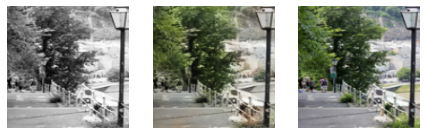

In [120]:
#1
show_colorized_img_srgb(230, 231)

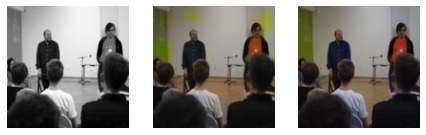

In [162]:
#2
show_colorized_img_srgb(107, 108)

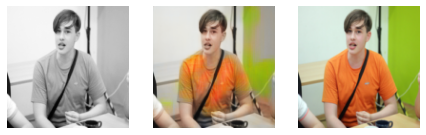

In [234]:
#3
show_colorized_img_srgb(151, 152)

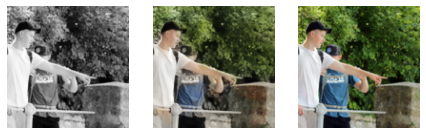

In [244]:
#4
show_colorized_img_srgb(164, 165)

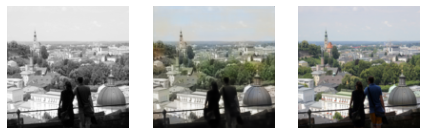

In [269]:
#5
show_colorized_img_srgb(231, 232)

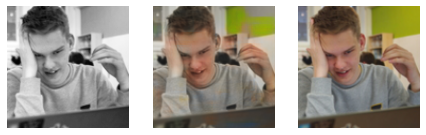

In [287]:
#6
show_colorized_img_srgb(289, 290)

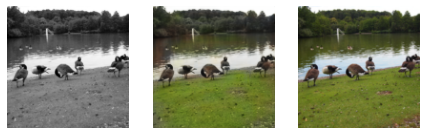

In [363]:
#7
show_colorized_img_srgb(330, 331)

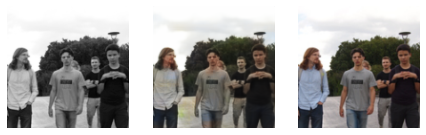

In [402]:
#8
show_colorized_img_srgb(344, 345)

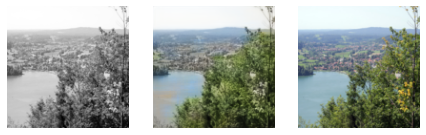

In [426]:
#9
show_colorized_img_srgb(460, 461)

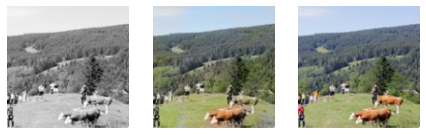

In [454]:
#10
show_colorized_img_srgb(521, 522)

*HSV*

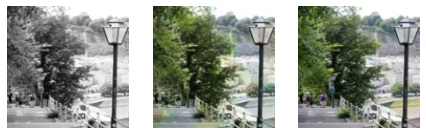

In [194]:
#1
show_colorized_img_hsv(230, 231)

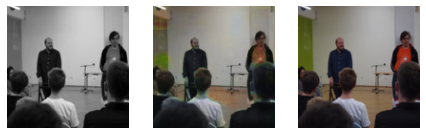

In [177]:
#2
show_colorized_img_hsv(107, 108)

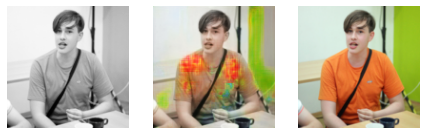

In [237]:
#3
show_colorized_img_hsv(151, 152)

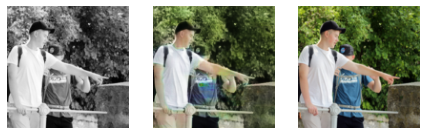

In [247]:
#4
show_colorized_img_hsv(164, 165)

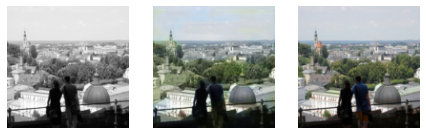

In [272]:
#5
show_colorized_img_hsv(231, 232)

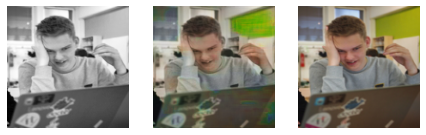

In [299]:
#6
show_colorized_img_hsv(289, 290)

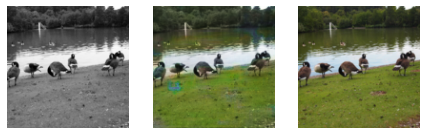

In [365]:
#7
show_colorized_img_hsv(330, 331)

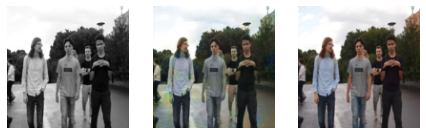

In [400]:
#8
show_colorized_img_hsv(344, 345)

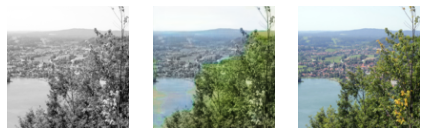

In [436]:
#9
show_colorized_img_hsv(460, 461)

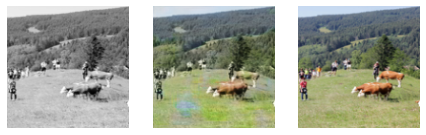

In [474]:
#10
show_colorized_img_hsv(521, 522)

*CIELAB*

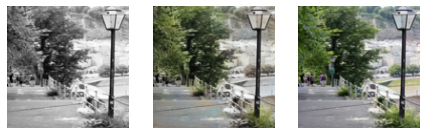

In [89]:
#1
show_colorized_img_lab(230, 231)

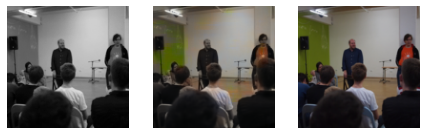

In [215]:
#2
show_colorized_img_lab(107, 108)

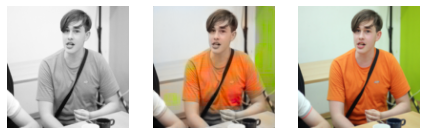

In [227]:
#3
show_colorized_img_lab(151, 152)

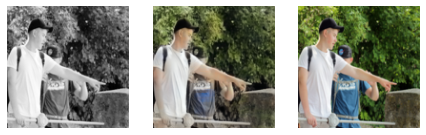

In [260]:
#4
show_colorized_img_lab(164, 165)

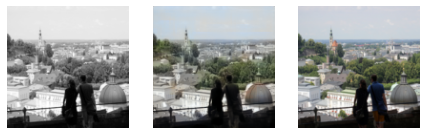

In [275]:
#5
show_colorized_img_lab(231, 232)

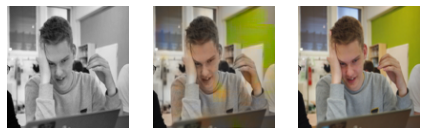

In [347]:
#6
show_colorized_img_lab(289, 290)

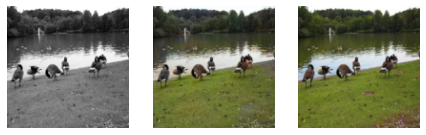

In [370]:
#7
show_colorized_img_lab(330, 331)

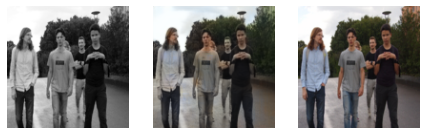

In [413]:
#8
show_colorized_img_lab(344, 345)

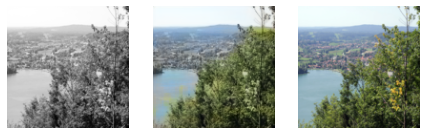

In [446]:
#9
show_colorized_img_lab(460, 461)

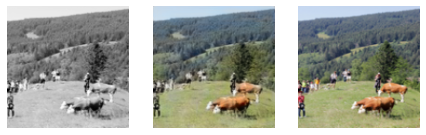

In [480]:
#10
show_colorized_img_lab(521, 522)